In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf

2024-04-22 13:37:04.750478: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 13:37:04.775068: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 13:37:04.964206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 13:37:04.964346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 13:37:04.995742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
np.set_printoptions(suppress=True)

RNG = np.random.default_rng(1069)

In [3]:
N_OBS = 4000
(DISP_X, DISP_Y) = (2560, 1080)
PARAM_NAMES = [r"$\mu$", r"$\sigma$"]

Brute-force simulation to make sure that this is not stupid.

<Axes: >

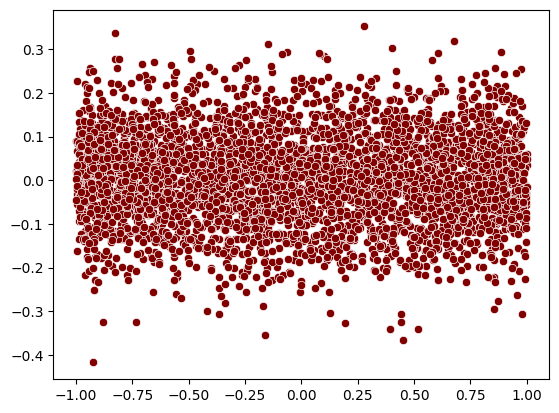

In [4]:
y = RNG.normal(0., 0.1, size=N_OBS)
x = RNG.uniform(-1., 1., size=N_OBS)

sns.scatterplot(x=x, y=y, color='maroon')

Properly-defined prior and simulator for BayesFlow.

In [5]:
def prior_fun(rng=None):
    """
    Generate prior parameters for vertical gaze distribution.
    """
    if rng is None:
        rng = np.random.default_rng()

    mu = rng.normal(0, 1)
    sigma = rng.gamma(2, 2)

    theta = np.array([mu, sigma])

    return theta

In [6]:
def gaze_simulator_fun(theta, N_OBS=1000, rng=None):

    mu, sigma = theta

    if rng is None:
        rng = np.random.default_rng()


    x = rng.uniform(-1., 1., size=N_OBS)
    y = rng.normal(mu, sigma, size=N_OBS)

    gaze_xy = np.array([x, y])
    return gaze_xy

Again simulating in brute force.

<Axes: >

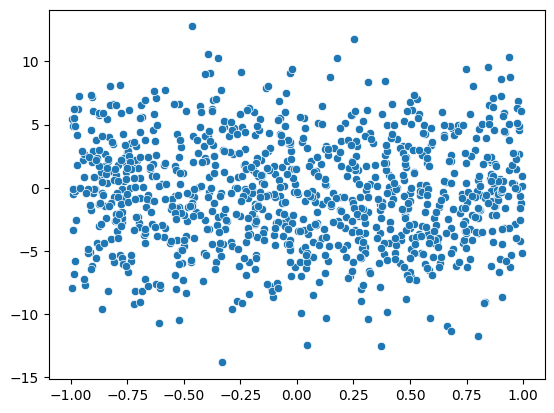

In [7]:
theta = prior_fun()
gaze_xy = gaze_simulator_fun(theta, N_OBS=1000)

sns.scatterplot(x=gaze_xy[0], y=gaze_xy[1])

Wrapping them up with `bf.simulation`.

In [8]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAM_NAMES)

Prior predictive check

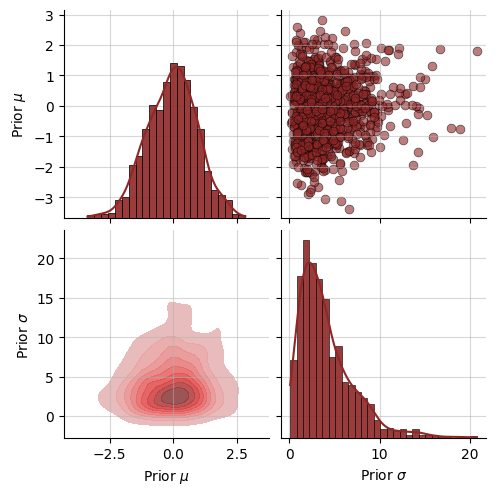

In [9]:
# Prior predictive check
f = bf.diagnostics.plot_prior2d(prior=prior, n_samples=1000, param_names=PARAM_NAMES)

### Generative Model

In [10]:
model = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=gaze_simulator_fun,
    name="gaze",
    simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the gaze model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 1000)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [11]:
sim = model(100)

In [12]:
sim

{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[-0.73626329,  1.64468999],
        [-0.132185  ,  6.25131506],
        [ 0.424144  ,  0.97545398],
        [ 0.22409302,  0.8733051 ],
        [-0.38096636,  3.36163808],
        [-1.92277419,  2.73620969],
        [-0.35011854,  5.13970935],
        [-0.26551969,  6.45729721],
        [ 0.81268678,  0.68524199],
        [-0.20471349,  1.07481561],
        [ 0.80721967,  4.84528613],
        [ 0.9012166 ,  3.5085069 ],
        [ 1.30784436,  5.94868292],
        [-0.31518899,  3.25742976],
        [-0.26362145,  5.02576162],
        [-0.33338422,  1.93055802],
        [-0.42867772,  2.93730589],
        [ 0.17635941,  5.04416637],
        [ 0.4780017 ,  1.2770344 ],
        [-0.07116341,  1.43445856],
        [ 0.76597892,  8.40169976],
        [ 2.48071072, 11.18377487],
        [ 1.51186905,  2.51063658],
        [ 0.8861361 , 10.67879845],
        [-1.32281489,  2.14371241],
        [ 0.0

### Neural Approximator

In [13]:
summary_net = bf.summary_networks.DeepSet()

2024-04-22 13:37:13.934302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 13:37:13.934883: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
inference_net = bf.inference_networks.InvertibleNetwork(num_params=len(PARAM_NAMES))

In [15]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

In [16]:
def configurator(forward_dict):
    out_dict = {}

    out_dict["parameters"] = forward_dict["prior_draws"]
    out_dict["summary_conditions"] = forward_dict["sim_data"]

    return out_dict

In [17]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [18]:
amortizer.summary()

Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  436296    
 ibleNetwork)                                                    
                                                                 
 deep_set (DeepSet)          multiple                  195210    
                                                                 
Total params: 631506 (2.41 MB)
Trainable params: 631482 (2.41 MB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


In [19]:
losses = trainer.train_online(epochs=10, iterations_per_epoch=100, batch_size=32)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

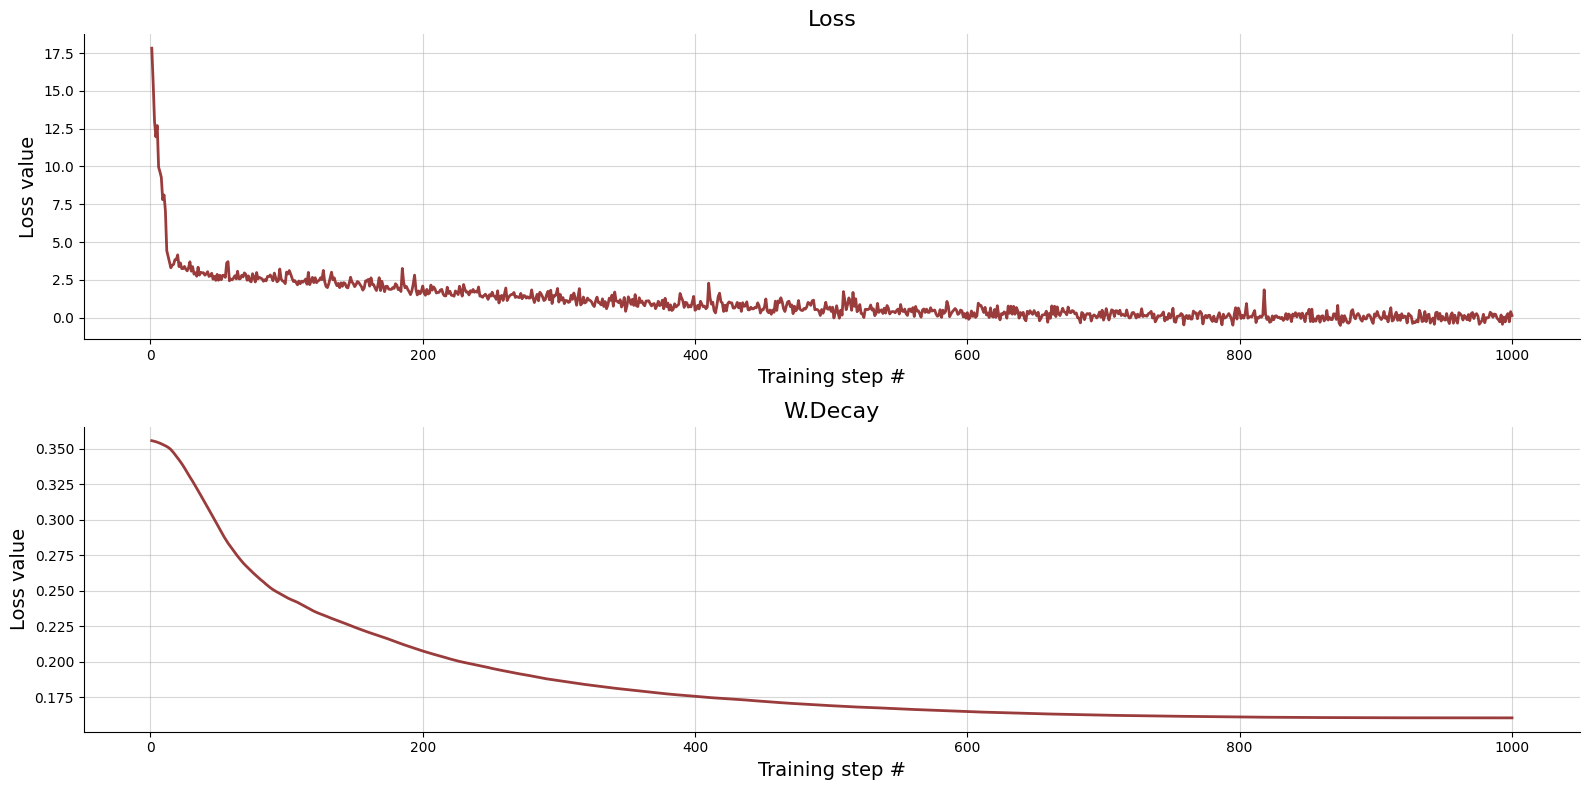

In [20]:
f = bf.diagnostics.plot_losses(losses)

<Axes: >

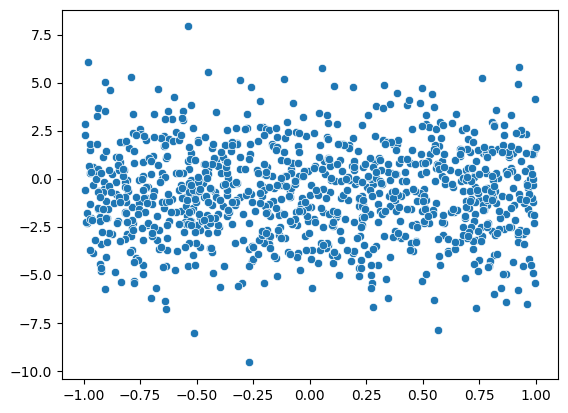

In [21]:
## Parameter recovery
resim = configurator(model(500))
resim['summary_conditions'].shape
s = resim['summary_conditions'][0]
sns.scatterplot(x=s[0], y=s[1])

In [22]:
post_samples = amortizer.sample(resim, n_samples=1000)
post_samples.shape

(500, 1000, 2)

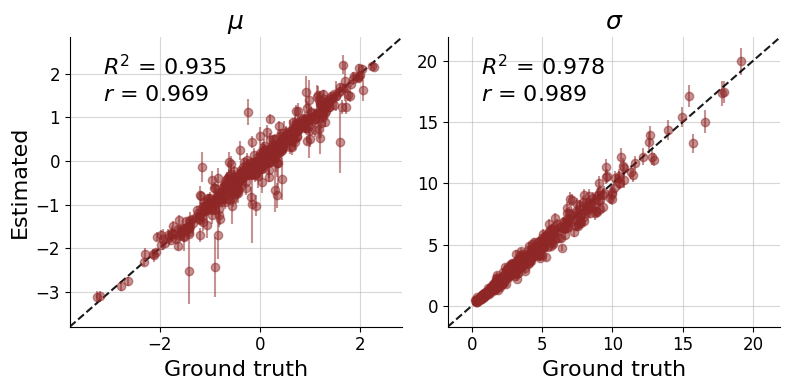

In [23]:
f = bf.diagnostics.plot_recovery(post_samples, resim['parameters'], param_names=PARAM_NAMES)

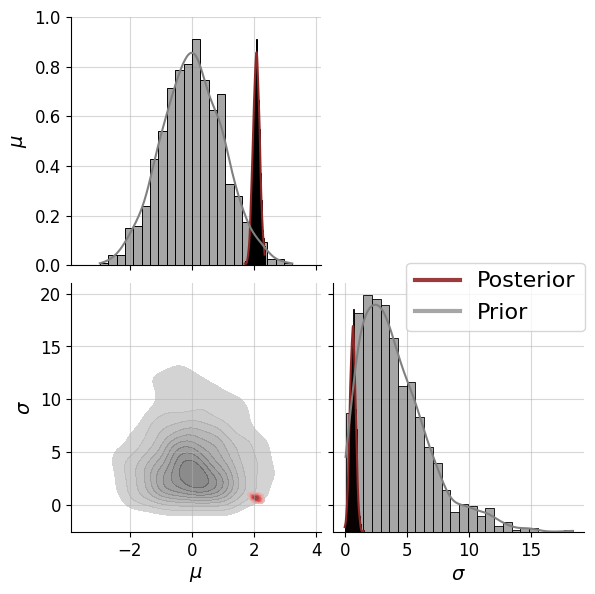

In [67]:
f = bf.diagnostics.plot_posterior_2d(post_samples[0], prior=prior)

<Axes: >

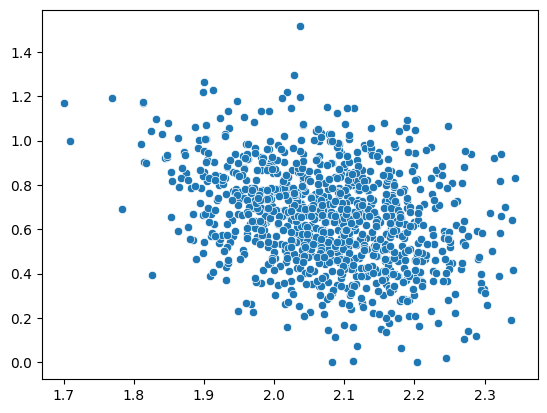

In [68]:
samples = post_samples[0]
sns.scatterplot(x=samples[:,0], y=samples[:,1])